In [59]:
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3
import numpy as np

In [77]:
data = data_load(data_keys={'bodyport', 'oura_activity', 'oura_sleep', "surveys"})



In [61]:
data['bodyport']['subsource'].unique()
# subsource is only `weight`

array(['weight'], dtype=object)

In [134]:
data_bodyport = data['bodyport']
users = data_bodyport['user_id'].unique().tolist()
most_data_user = -1
most_data = -1
for u in users:
    num_data = len(data_bodyport[data_bodyport['user_id'] == u])
    if num_data > most_data:
        most_data = num_data
        most_data_user = u
most_data_user
# userid 74 has the most data

74

In [264]:
selected_user = 74
selected_data_bodyport = data_bodyport[data_bodyport['user_id'] == selected_user][['date', 'impedance_ratio', 'peripheral_fluid', 'impedance_mag_1_ohms', 'impedance_phase_1_degs', 'weight_kg']].groupby("date", as_index = False).mean()


In [265]:
data_oura_activity = data['oura_activity']
data_oura_activity[data_oura_activity['user_id'] == selected_user]
data_oura_sleep = data['oura_sleep']

In [266]:
selected_data_oura_activity = data_oura_activity[data_oura_activity['user_id'] == selected_user][[
 'cal_active',
 'cal_total',
 'daily_movement',
 'high',
 'inactive',
#  'inactivity_alerts',
 'low',
 'medium',
 'met_min_high',
 'met_min_inactive',
 'met_min_low',
 'met_min_medium',
 'non_wear',
 'rest',
#  'rest_mode_state',
#  'score',
#  'score_meet_daily_targets',
#  'score_move_every_hour',
#  'score_recovery_time',
#  'score_stay_active',
#  'score_training_frequency',
#  'score_training_volume',
 'steps',
 'date']]

In [267]:
def get_min_date(df):
    return np.min(df['date'])
def get_max_date(df):
    return np.max(df['date'])

In [268]:

# # union
# overall_min_date = np.min([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
# overall_max_date = np.max([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

# intercept
overall_min_date = np.max([get_min_date(selected_data_bodyport), get_min_date(selected_data_oura_activity)])
overall_max_date = np.min([get_max_date(selected_data_bodyport), get_max_date(selected_data_oura_activity)])

date_range = pd.date_range(overall_min_date, overall_max_date, freq='d')
date_df = pd.DataFrame()
date_df['date'] = date_range
selected_data_bodyport['date'] = selected_data_bodyport['date'].astype('datetime64')
selected_data_oura_activity['date'] = selected_data_oura_activity['date'].astype('datetime64')
selected_data_bodyport = pd.merge(date_df, selected_data_bodyport, how='left')
selected_data_oura_activity = pd.merge(date_df, selected_data_oura_activity, how='left')

unimputed_df = pd.DataFrame()
unimputed_df['date'] = date_range
unimputed_df = pd.merge(unimputed_df, selected_data_bodyport, how='left')
unimputed_df = pd.merge(unimputed_df, selected_data_oura_activity, how='left')
np.sum(unimputed_df.isna())
date_range

DatetimeIndex(['2021-07-30', '2021-07-31', '2021-08-01', '2021-08-02',
               '2021-08-03', '2021-08-04', '2021-08-05', '2021-08-06',
               '2021-08-07', '2021-08-08',
               ...
               '2022-04-17', '2022-04-18', '2022-04-19', '2022-04-20',
               '2022-04-21', '2022-04-22', '2022-04-23', '2022-04-24',
               '2022-04-25', '2022-04-26'],
              dtype='datetime64[ns]', length=271, freq='D')

In [269]:
# fill missing days with randomly selected days from previous 14 days window
np.random.seed(90)
activity_mask = selected_data_oura_activity.drop('date', axis=1).isna().all(1)
bodyport_mask = selected_data_bodyport.drop('date', axis=1).isna().all(1)
def random_fill_missing_day(df, mask, window=30):
    if 'date' in df.columns.to_list(): 
        df = df.drop('date', axis=1)
    for i in range(len(mask)):
        if mask[i]:
            if i < window: # do random filling
                available_indice = np.where(mask == False)[0]
                random_observation = df.iloc[np.random.choice(available_indice)]
            else:
                random_index = np.random.randint(low=1, high=window)

                random_observation = df.iloc[i-random_index]
                # print(':',i-random_index)
                # print(i)
                # print(random_index)

            df.iloc[i] = random_observation

    return df
random_filled_oura_activity = random_fill_missing_day(selected_data_oura_activity.drop('date', axis=1), activity_mask)
#np.sum(out.isna().all(1))
random_filled_bodyport = random_fill_missing_day(selected_data_bodyport.drop('date', axis=1), bodyport_mask)
random_filled_oura_activity['date'] = date_range
random_filled_bodyport['date'] = date_range

overall_df = pd.merge(random_filled_oura_activity, random_filled_bodyport, how='left')
overall_df.loc[overall_df['impedance_ratio'] > 10,'impedance_ratio'] = np.nan

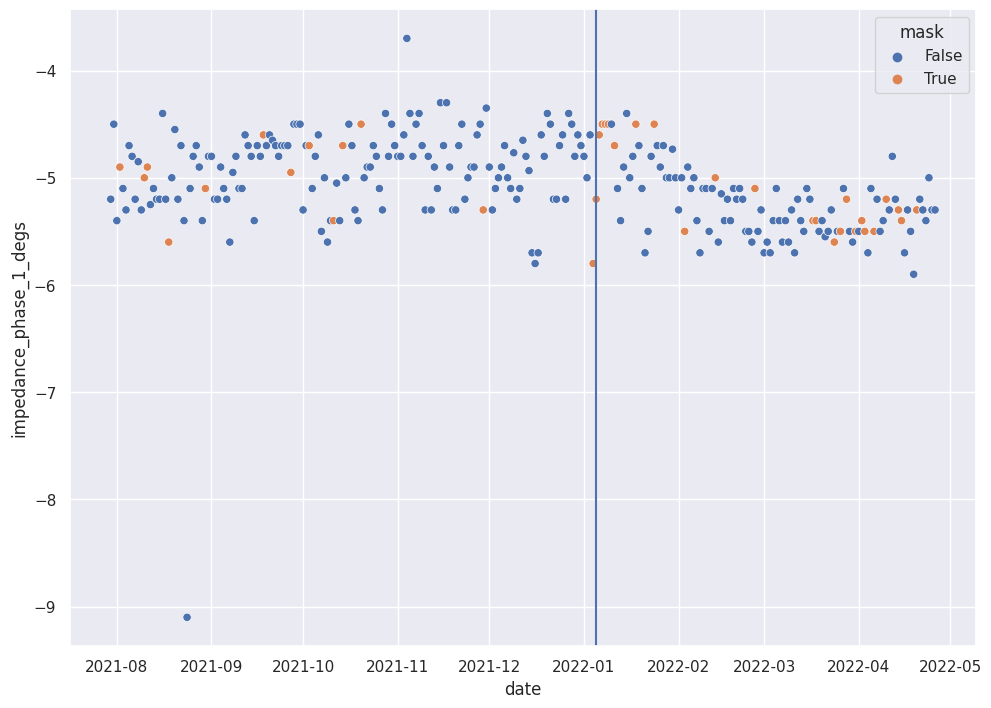

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.scatterplot(x=overall_df["date"], y=overall_df["non_wear"], hue=unimputed_df['non_wear'].isna())
overall_df['mask'] = unimputed_df['impedance_phase_1_degs'].isna()
graph = sns.scatterplot(data=overall_df, x="date", y="impedance_phase_1_degs", hue="mask")

df_birth = data_load(data_keys={'birth'})['birth']
df_birth[df_birth.user_id == 74].birth_date.values[0]
graph.axvline(pd.to_datetime(df_birth[df_birth.user_id == selected_user].birth_date.values[0]))

In [271]:
np.sum(overall_df.isna())

cal_active                0
cal_total                 0
daily_movement            0
high                      0
inactive                  0
low                       0
medium                    0
met_min_high              0
met_min_inactive          0
met_min_low               0
met_min_medium            0
non_wear                  0
rest                      0
steps                     0
date                      0
impedance_ratio           2
peripheral_fluid          0
impedance_mag_1_ohms      0
impedance_phase_1_degs    0
weight_kg                 0
mask                      0
dtype: int64

In [272]:
overall_df.describe()

,cal_active,cal_total,daily_movement,high,inactive,low,medium,met_min_high,met_min_inactive,met_min_low,met_min_medium,non_wear,rest,steps,impedance_ratio,peripheral_fluid,impedance_mag_1_ohms,impedance_phase_1_degs,weight_kg
count,271.000000,271.000000,271.00000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,271.000000,269.000000,271.000000,271.000000,271.000000,271.000000
mean,170.723247,1840.011070,3602.01476,0.221402,471.420664,200.586716,12.926199,1.405904,9.815498,122.424354,39.819188,284.125461,467.166052,4405.690037,1.112014,1.486116,673.633764,-5.059717,53.384499
std,115.384771,179.882194,2690.92983,0.646116,193.156644,118.965910,13.830257,4.125508,4.382953,78.918904,42.306647,313.919627,116.470176,2798.419369,0.014400,0.106915,38.834460,0.446597,2.936288
min,3.000000,1396.000000,11.00000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,17.000000,108.000000,1.080000,0.450000,518.000000,-9.100000,48.920000
25%,78.000000,1679.500000,1413.50000,0.000000,348.500000,97.000000,3.000000,0.000000,7.000000,53.500000,8.000000,36.000000,416.000000,2192.500000,1.100000,1.430000,646.500000,-5.300000,51.520000
50%,158.000000,1843.000000,3210.00000,0.000000,499.000000,205.000000,9.000000,0.000000,10.000000,116.000000,28.000000,143.000000,483.000000,4154.000000,1.110000,1.490000,670.000000,-5.100000,52.280000
75%,242.500000,1968.000000,5239.00000,0.000000,621.000000,296.000000,18.000000,0.000000,13.000000,181.000000,57.000000,469.000000,542.500000,6312.500000,1.120000,1.550000,699.000000,-4.700000,55.795000
max,565.000000,2354.000000,13036.00000,5.000000,924.000000,480.000000,76.000000,33.000000,21.000000,348.000000,226.000000,1314.000000,699.000000,12739.000000,1.150000,1.930000,766.000000,-3.700000,61.420000


In [273]:
# hyperimpute requires python 3.7
from hyperimpute.plugins.imputers import Imputers
import numpy as np
imputers = Imputers()

imputers.list()
method = 'hyperimpute'
plugin = Imputers().get(method)
X = overall_df.drop('date', axis=1).drop('mask', axis=1)
out = plugin.fit_transform(X.copy())

print(method, out)

hyperimpute      cal_active  cal_total  daily_movement  high  inactive    low  medium  \
0          38.0     2089.0           445.0   0.0     236.0   40.0     3.0   
1         406.0     2146.0          9554.0   0.0     448.0  346.0    32.0   
2         156.0     1858.0          3001.0   0.0     714.0  194.0    13.0   
3         187.0     1876.0          3492.0   0.0     438.0  257.0    11.0   
4          84.0     1761.0          1463.0   0.0     801.0  130.0     2.0   
..          ...        ...             ...   ...       ...    ...     ...   
266        29.0     1681.0           271.0   0.0     310.0   47.0     1.0   
267        38.0     1703.0           434.0   0.0     651.0   55.0     0.0   
268        31.0     1659.0           229.0   0.0     583.0   53.0     0.0   
269       125.0     1789.0          2421.0   0.0     502.0  109.0    13.0   
270        11.0     1526.0           202.0   0.0      57.0   13.0     0.0   

     met_min_high  met_min_inactive  met_min_low  met_min_mediu

In [274]:
hyperimputed_df_without_date = out
hyperimputed_df_without_date.to_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_hyperimpute.csv', index=False, header=False)

In [275]:
hyperimputed_df_with_date = hyperimputed_df_without_date.copy()
hyperimputed_df_with_date['date'] = date_range
hyperimputed_df_with_date.to_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_hyperimpute_with_date.csv', index=False)

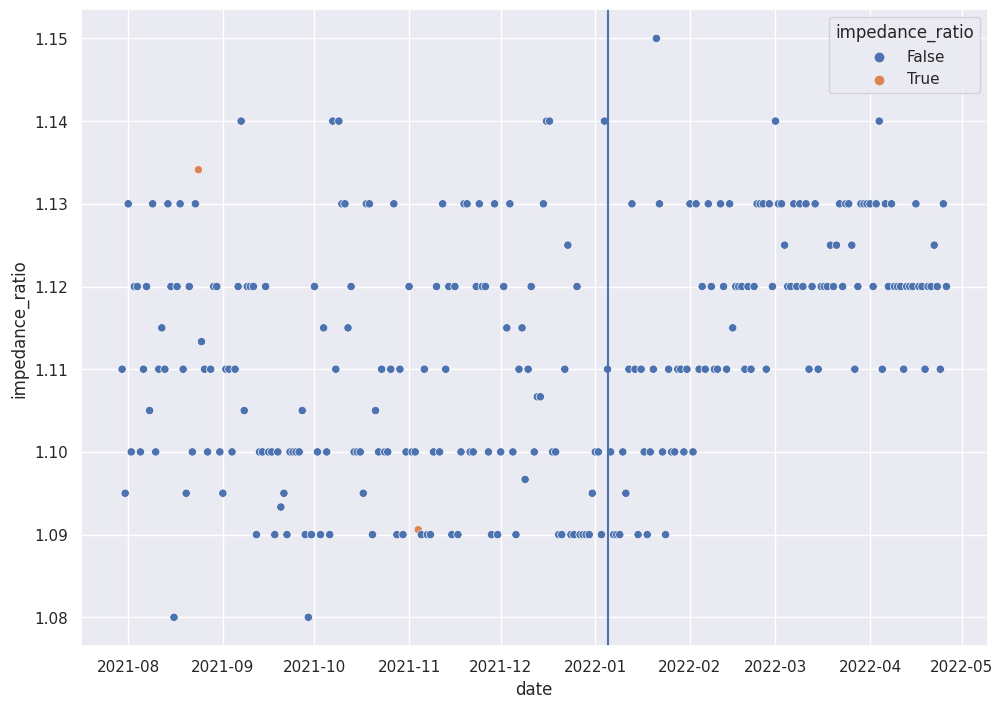

In [276]:
g2 = sns.scatterplot(x=hyperimputed_df_with_date["date"], y=hyperimputed_df_without_date["impedance_ratio"], hue=overall_df['impedance_ratio'].isna())
g2.axvline(pd.to_datetime(df_birth[df_birth.user_id == selected_user].birth_date.values[0]))

In [277]:
overall_df_without_date = overall_df.drop('date', axis=1)
overall_df_without_date.to_csv(f'/mnt/results/user_{selected_user}_activity_bodyport_rand_filled.csv', index=False, header=False)

In [278]:
# handle survey
df_survey = data['surveys']
df_puqe = data['surveys'].loc[data['surveys']['title']=='PUQE']
selected_user_puqe = df_puqe[df_puqe['user_id'] == selected_user]

In [279]:

answer_dict = {
    'No': 1,
    'Yes': 2,
    'Not at all': 1,
    '1 hour or less': 2,
    '2 to 3 hours':3, 
    '4 to 6 hours':4, 
    '6 or more hours':5,
    '1-2 times': 2,
    '3-4 times': 3,
    '5-6 times': 4,
    '7 or more times': 5
}

answer_catagory = {
    (0, 6) : 0,
    (7, 12): 1,
    (13, 21): 2
}
def map_levels(x, map_dict):
    for key in map_dict:
        if isinstance(x, str):
            if x == key:
                return map_dict[key]
        else:
            if x >= key[0] and x <= key[1]:
                return map_dict[key]
# 53, 54, 132, 404
# 404: 'During the past week, did you experience any nausea?'
# 132: 'On average in a day, for how long do you feel nauseated or sick to your stomach?'
# 53: 'On average in a day, how many times do you vomit or throw up?'
# 54: 'On average in a day, how many times have you had retching or dry heaves without bringing anything up?'

# for qid in selected_user_puqe['question_id'].unique():
#     question_df = selected_user_puqe.loc[selected_user_puqe['question_id'] == qid]
#     question_df['answer_text'] = question_df['answer_text'].astype(object)
#     print(question_df['answer_text'])
#     if qid == 404:
#         question_df.replace({"answer_text": answer_dict1}, inplace=True)
#     elif qid == 132:
#         question_df.replace({"answer_text": answer_dict2}, inplace=True)
#     else:
#         question_df.replace({"answer_text": answer_dict3}, inplace=True)
selected_user_puqe['answer_text'] = selected_user_puqe['answer_text'].astype(object)
selected_user_puqe.replace({"answer_text": answer_dict}, inplace=True)
aggregated_user_puqe = selected_user_puqe.groupby('date', as_index=False).sum()
for k in answer_catagory:
    aggregated_user_puqe['answer_text'] = np.where(aggregated_user_puqe['answer_text'].between(k[0],k[1]), answer_catagory[k], aggregated_user_puqe['answer_text'])

aggregated_user_puqe.to_csv(f'/mnt/results/user_{selected_user}_puqe.csv', index=False, header=True)

In [280]:
df = pd.read_csv(f'/mnt/results/user_{selected_user}_puqe.csv')

In [281]:
df

,date,id,user_id,survey_id,question_id,answer_text
0,2021-07-31,769652,1160,8,643,1
1,2021-08-06,825888,1160,8,643,1
2,2021-08-12,893888,1160,8,643,1
3,2021-08-20,955368,1160,8,643,1
4,2021-08-26,1023532,1160,8,643,1
5,2021-09-02,1098472,1160,8,643,1
6,2021-09-10,1179108,1160,8,643,0
7,2021-09-16,1261096,1160,8,643,1
8,2021-09-24,1344344,1160,8,643,1
9,2021-10-01,1437520,1160,8,643,1
